<a href="https://colab.research.google.com/github/jlsneto/kmeans-with-images/blob/master/K_means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Baixar e extrair base de dados

In [0]:
import os
data_set_path = "/content/fingers.zip"
download_link = "https://doc-0o-bg-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/u1god424bhf4osk2oo3akkjmdhcfgo6j/1573524000000/10719298919191037505/*/1QA2idrUmPZJ2NRQhv-GUuJuSrdM0QqYR?e=download"
#download dataset
if not os.path.exists(data_set_path):
    !curl "{download_link}" --output "{data_set_path}"
    !unzip -qq "{data_set_path}"

In [0]:
%matplotlib inline
!pip install cereja

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
import numpy as np
import imutils
from matplotlib.pyplot import imshow

#Utils

In [0]:
from cereja.utils import path as cj
from cereja.utils import decorators

@decorators.time_exec
def load_data(path: str, segment_hands=True):
    k = 2
    x_train = []
    labels = []
    for p in cj.group_path_from_dir(path, 1, 'png'):
        labels.append(int(p[0].rsplit('_', -1)[1][0]))
        img = cv2.imread(p[0])
        img = cv2.resize(img, (64,64))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_shape = img.shape
        img = img.reshape((-1,3))
        img = np.float32(img)
        if segment_hands:
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
            attempts=10
            ret,label,center=cv2.kmeans(img,k,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
            center = np.uint8(center)
            res = center[label.flatten()]
            img = res.reshape((img_shape))
        x_train.append(img)
    return np.array(x_train), np.array(labels)

# Carrega as imagens

In [89]:
x_train, x_train_labels = load_data("/content/train", False)
x_test, x_test_labels = load_data("/content/test", False)

[load_data] performed 6.401649713516235
[load_data] performed 1.3629958629608154


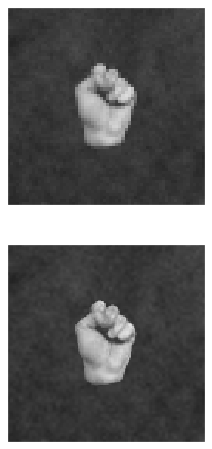

In [79]:
train = x_train

#normalize
train = train/255.

x = train.reshape((train.shape[0], -1))
x.shape

fig, ax = plt.subplots(2, 1, figsize=(8, 8))
img_examples = [x[0].reshape((64, 64, 3)), cv2.imread('/content/train/00048bba-979b-4f84-b833-5bbbb082b582_0L.png')]
for axi, center in zip(ax.flat, img_examples):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

#K-Means

In [80]:
from sklearn.cluster import KMeans
n_clusters = 12 # existem 6 sinais diferentes de cada mão portanto são 12 clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters = kmeans.fit_predict(x)
kmeans.cluster_centers_.shape

(12, 12288)

#O resultado são 12 clusters na dimensão 12288.

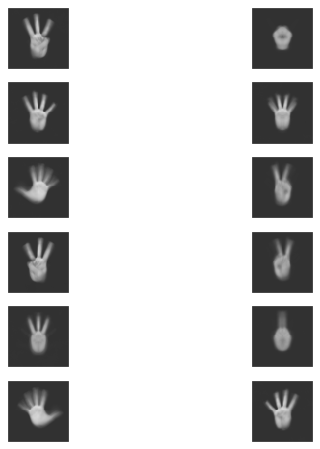

In [81]:
fig, ax = plt.subplots(6, 2, figsize=(8, 8))
centers = kmeans.cluster_centers_.reshape(n_clusters, 64, 64, 3)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(np.float32(center), interpolation='nearest', cmap=plt.cm.binary)

In [102]:
from scipy.stats import mode
from sklearn.metrics import accuracy_score
labels = np.zeros_like(clusters)
y = x_train_labels
for i in range(n_clusters):
    mask = (clusters == i)
    labels[mask] = mode(y[mask])[0]

print(f"acc: {accuracy_score(y, labels)}")

acc: 0.902


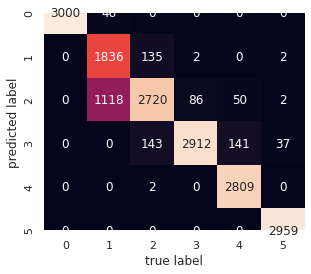

In [103]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

#Extra

In [0]:
#@title
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(x)

# Compute the clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(n_clusters):
    mask = (clusters == i)
    labels[mask] = mode(y[0][mask])[0]

# Compute the accuracy
accuracy_score(y, labels)